In [1036]:
import os
os.environ["OMP_NUM_THREADS"] = '1'
import torch
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as sk
import zipfile

import torch.nn as nn
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler, Subset
from sklearn.cluster import KMeans

In [ ]:
with zipfile.ZipFile('eyes_pack.zip', 'r') as zip_ref:
  zip_ref.extractall('.')

In [ ]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Load the face detector
detector = dlib.get_frontal_face_detector()

# Load the facial landmark predictor
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

Using cpu device


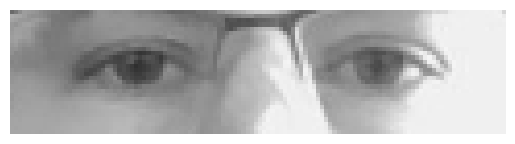

True

In [ ]:
def get_cropped_eyes(gray_image, face):
    # Detect face landmarks
    landmarks = predictor(gray_image, face)
    left_eye = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)], np.int32)
    right_eye = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)], np.int32)
    
    # Calculate the angle of the face
    angle = np.arctan2(right_eye[0][1] - left_eye[0][1], right_eye[0][0] - left_eye[0][0]) * 180 / np.pi
    
    # Rotate the image around the center of the eyes
    (h, w) = gray_image.shape[:2]
    meany = np.mean(np.concatenate([left_eye[:,0],right_eye[:,0]]), dtype=np.float32)
    meanx = np.mean(np.concatenate([left_eye[:,1],right_eye[:,1]]), dtype=np.float32)
    center = (meany//1, meanx//1)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(gray_image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT)
    
    left_eye_rotated = np.dot(M[:, :], np.vstack((left_eye.T, np.ones_like(left_eye[:,0])))).T.astype(np.int32)
    right_eye_rotated = np.dot(M[:, :], np.vstack((right_eye.T, np.ones_like(right_eye[:,0])))).T.astype(np.int32)
    #print(center)
    #print(angle)
    
    # Crop around the eyes
    x_axis = np.concatenate([left_eye_rotated[:,0],right_eye_rotated[:,0]])
    y_axis = np.concatenate([left_eye_rotated[:,1],right_eye_rotated[:,1]])
    x_min = np.min(x_axis)
    x_max = np.max(x_axis)
    y_min = np.min(y_axis)
    y_max = np.max(y_axis)
    
    x_range = x_max - x_min
    y_range = y_max - y_min
    
    right = round(.25 * x_range) + x_max
    left = x_min - round(.25 * x_range)
    bottom = round(.13 * x_range) + y_max
    top = y_min - round(.13 * x_range)
        
    max_width, max_height = rotated.shape
    right = np.minimum(right, max_width)
    left = np.maximum(left, 0)
    top = np.minimum(top, max_height)
    bottom = np.maximum(bottom, 0)
    # crop the image
    cropped = rotated[top:(bottom + 1), left:(right + 1)]
    
    # Resize the image
    cropped = cv2.resize(cropped, (120, 30))
    return cropped

image = cv2.imread("glasses1_open.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = detector(gray)    
# Iterate over detected faces
for face in faces:
    eyes = get_cropped_eyes(gray, face)

# Display the cropped image
plt.imshow(cv2.cvtColor(eyes, cv2.COLOR_GRAY2RGB))
plt.axis('off')
plt.show()
#cv2.imwrite('./my_glassesopen1b.jpg', cv2.cvtColor(eyes, cv2.COLOR_GRAY2RGB))

In [ ]:
# Define data transformations
data_transforms = {
    'train' :   transforms.Compose([
                    transforms.Grayscale(),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomVerticalFlip(p=0.5),
                    transforms.ColorJitter(brightness=0.5, contrast=0.5),
                    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
                    transforms.ToTensor(),  # Convert image to tensor
                    transforms.Normalize((0.5,), (0.5,))  # Normalize image data
                ]),
    'test' : transforms.Compose([
                    transforms.Grayscale(),
                    transforms.ToTensor(),  # Convert image to tensor
                    transforms.Normalize((0.5,), (0.5,))  # Normalize image data
                ]),
}

train_dataset = datasets.ImageFolder(root='./eyes', transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(root='./eyes', transform=data_transforms['test'])
train_idx, val_idx = sk.train_test_split(np.arange(len(train_dataset)), test_size=0.15, random_state=42)
train_idx.sort()
val_idx.sort()

train_dataset = Subset(train_dataset, train_idx)
test_dataset = Subset(test_dataset, val_idx)
full_dataset = datasets.ImageFolder(root='./eyes', transform=data_transforms['test'])

print(full_dataset.classes)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
full_loader = torch.utils.data.DataLoader(full_dataset, batch_size=len(full_dataset), shuffle=False)

In [506]:
def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    while True:
        ret, frame = cap.read()
        if ret:
            
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = detector(gray)
    
            # Iterate over detected faces
            for face in faces:
                eyes = get_cropped_eyes(gray, face)
                cv2.imshow("Frame", cv2.cvtColor(eyes, cv2.COLOR_BGR2RGB))
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

#process_video("blink.mp4")
process_video(0)

In [328]:
# when doing kmeans clustering, make sure the order of clusters follows the same indexes of samples that produced them
def align_cluster_centers(pred_labels, actual_labels, cluster_centers):
    # Create a dictionary to store the mode of actual labels for each cluster
    cluster_modes = {}

    # Compute the mode of actual labels for each cluster
    for pred_label, actual_label in zip(pred_labels, actual_labels):
        pred_label = pred_label.item()
        actual_label = actual_label.item()
        if pred_label not in cluster_modes :
            cluster_modes[pred_label] = {}
        if actual_label not in cluster_modes[pred_label]:
            cluster_modes[pred_label][actual_label] = 0
        cluster_modes[pred_label][actual_label] += 1

    rearranged_centers = torch.zeros_like(cluster_centers)
    for cluster, mode_dict in cluster_modes.items():
        mode_label = max(mode_dict, key=mode_dict.get)
        rearranged_centers[mode_label] = cluster_centers[cluster]
        
    return rearranged_centers

['closed', 'open']
torch.Size([30, 120, 3])
tensor([0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1])


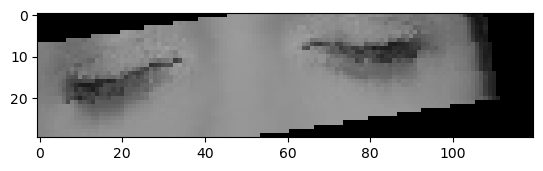

In [1019]:

class BlinkDetectionCNN(nn.Module):
    def __init__(self):
        super(BlinkDetectionCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 29 * 7, 128)
        self.fc2 = nn.Linear(128, 2)  # 2 output classes: eyes open or closed
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.cluster_centers = None
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 32 * 29 * 7)
        fc1 = self.fc1(x)
        x = self.dropout(self.relu(fc1))
        x = self.fc2(x)
        return x, fc1

    def set_embedding(self, embeddings, labels, pred_labels):
        kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto').fit(embeddings.detach().numpy())
        self.cluster_centers = nn.Parameter(torch.from_numpy(kmeans.cluster_centers_)).detach()
        self.cluster_centers = align_cluster_centers(pred_labels, labels, self.cluster_centers)

# Create an instance of the BlinkDetectionCNN model
model = BlinkDetectionCNN()





inputs, classes = next(iter(train_loader))
expanded_tensor = inputs[0].expand(3, -1, -1).permute(1,2,0)
print(expanded_tensor.shape)
image = Image.fromarray(np.uint8((expanded_tensor+1)/2*255))
plt.imshow(image)
#print(inputs)
print(classes)
#model(inputs)


In [1023]:
## Phase 1, train fc2 to the categories
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 500
for epoch in range(num_epochs):
    loss_sum = 0
    loss_count = 0
    acc_sum = 0
    test_loss_sum = 0
    test_loss_count = 0
    test_acc_sum = 0

    model.train()
    for data, labels in train_loader:  
        optimizer.zero_grad()
        
        prediction, emb = model(data)
        loss = loss_fn(prediction, labels)
        
        loss_sum += loss.item()
        loss_count += len(labels)
        acc_sum += (prediction.argmax(1) == labels).type(torch.float).sum().item()
        
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        for data, labels in test_loader:
            prediction, emb = model(data)
            loss = loss_fn(prediction, labels)
            
            test_loss_sum += loss.item()
            test_loss_count += len(labels)
            test_acc_sum += (prediction.argmax(1) == labels).type(torch.float).sum().item()
    
    #scheduler.step(loss_sum/loss_count)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss_sum/loss_count}, Acc: {acc_sum/loss_count}")
        print(f"Epoch {epoch}, Test Loss: {test_loss_sum/test_loss_count}, Acc: {test_acc_sum/test_loss_count}")

Epoch 0, Loss: 0.029988555804542873, Acc: 0.5652173913043478
Epoch 0, Test Loss: 0.13467893600463868, Acc: 0.8
Epoch 10, Loss: 0.029555325922758682, Acc: 0.5652173913043478
Epoch 10, Test Loss: 0.14295518398284912, Acc: 0.6
Epoch 20, Loss: 0.02547024384788845, Acc: 0.7391304347826086
Epoch 20, Test Loss: 0.13987669944763184, Acc: 0.4
Epoch 30, Loss: 0.023337123186691948, Acc: 0.6956521739130435
Epoch 30, Test Loss: 0.14119771718978882, Acc: 0.8
Epoch 40, Loss: 0.024850847928420357, Acc: 0.6956521739130435
Epoch 40, Test Loss: 0.13343113660812378, Acc: 0.4
Epoch 50, Loss: 0.023776088071906048, Acc: 0.7391304347826086
Epoch 50, Test Loss: 0.1268756151199341, Acc: 0.6
Epoch 60, Loss: 0.02906527726546578, Acc: 0.4782608695652174
Epoch 60, Test Loss: 0.12497223615646362, Acc: 0.8
Epoch 70, Loss: 0.01998338880746261, Acc: 0.7391304347826086
Epoch 70, Test Loss: 0.13911263942718505, Acc: 0.4
Epoch 80, Loss: 0.021489162807879242, Acc: 0.8260869565217391
Epoch 80, Test Loss: 0.1416236639022827,

In [1003]:
def plot_correlation_matrix(correlation_matrix):
    plt.figure(figsize=(8, 6))
    plt.imshow(correlation_matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Correlation')
    plt.title('Correlation Matrix of fc1 Activations')
    plt.xlabel('Samples')
    plt.ylabel('Samples')
    plt.show()

In [1038]:
## set embedding centers
model.eval()
with torch.no_grad():
    for data, labels in train_loader:
        prediction, emb = model(data)
        model.set_embedding(emb, labels, prediction.argmax(1))

C:\Users\cdesu\anaconda3\envs\vision3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [1046]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, RocCurveDisplay, roc_curve, auc

def show_metrics(emb_model, data_loader):
    emb_model.eval()
    with torch.no_grad():
        for data, labels in data_loader:
            prediction, emb = emb_model(data)
            plot_correlation_matrix(torch.corrcoef(emb))
    
            predictions = prediction.argmax(1)
            accuracy = accuracy_score(labels, predictions) * 100
            f1 = f1_score(labels, predictions, average='macro')
            precision = precision_score(labels, predictions, average='macro')
            recall = recall_score(labels, predictions, average='macro')
            conf_matrix = confusion_matrix(labels, predictions)
            
            # Metrics output
            print("Metrics based on fc2 classification:")
            print(f"Accuracy: {accuracy:.3f}%")
            print(f"F1 Score: {f1:.3f}")
            print(f"Precision: {precision:.3f}")
            print(f"Recall: {recall:.3f}")
            print("Confusion Matrix:")
            print(conf_matrix)
            print("----")
            
            distances = torch.cdist(emb, emb_model.cluster_centers)
            predictions = distances.min(dim=1)[1].squeeze()
    
            accuracy = accuracy_score(labels, predictions) * 100
            f1 = f1_score(labels, predictions, average='macro')
            precision = precision_score(labels, predictions, average='macro')
            recall = recall_score(labels, predictions, average='macro')
            conf_matrix = confusion_matrix(labels, predictions)
            
            # Metrics output
            print("Metrics based on fc1 clustering:")
            print(f"Accuracy: {accuracy:.3f}%")
            print(f"F1 Score: {f1:.3f}")
            print(f"Precision: {precision:.3f}")
            print(f"Recall: {recall:.3f}")
            print("Confusion Matrix:")
            print(conf_matrix)


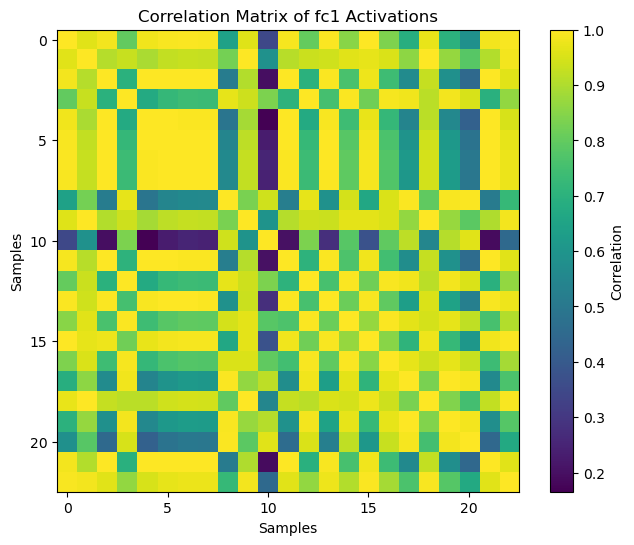

Metrics based on fc2 classification:
Accuracy: 65.217%
F1 Score: 0.589
Precision: 0.800
Recall: 0.636
Confusion Matrix:
[[ 3  8]
 [ 0 12]]
----
Metrics based on fc1 clustering:
Accuracy: 95.652%
F1 Score: 0.957
Precision: 0.958
Recall: 0.958
Confusion Matrix:
[[11  0]
 [ 1 11]]


In [1051]:
show_metrics(model, train_loader)

In [1025]:
## Phase 2, train fc1 to the cluster centers
loss_fn = nn.MSELoss()
num_epochs = 500
for epoch in range(num_epochs):
    loss_sum = 0
    loss_count = 0
    acc_sum = 0
    test_loss_sum = 0
    test_loss_count = 0
    test_acc_sum = 0

    model.train()
    for data, labels in train_loader:  
        optimizer.zero_grad()
        
        prediction, emb = model(data)

        loss = loss_fn(emb, model.cluster_centers[labels].squeeze())
        
        loss_sum += loss.item()
        loss_count += len(labels)
        
        distances = torch.cdist(emb, model.cluster_centers)
        pred_labels = distances.min(dim=1)[1]
        testY = labels.squeeze()            
        for i in range(len(pred_labels)):
            if pred_labels[i] == testY[i]:
                acc_sum += 1
        
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        for data, labels in test_loader:
            prediction, emb = model(data)   

            loss = loss_fn(emb, model.cluster_centers[labels].squeeze())
            
            test_loss_sum += loss.item()
            test_loss_count += len(labels)
            
            distances = torch.cdist(emb, model.cluster_centers)
            pred_labels = distances.min(dim=1)[1]
            testY = labels.squeeze()            
            for i in range(len(pred_labels)):
                if pred_labels[i] == testY[i]:
                    test_acc_sum += 1
    
    #scheduler.step(loss_sum/loss_count)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss_sum/loss_count}, Acc: {acc_sum/loss_count}")
        print(f"Epoch {epoch}, Test Loss: {test_loss_sum/test_loss_count}, Acc: {test_acc_sum/test_loss_count}")

Epoch 0, Loss: 0.14498145683952, Acc: 0.6521739130434783
Epoch 0, Test Loss: 0.4383810520172119, Acc: 0.6
Epoch 10, Loss: 0.06820134494615637, Acc: 0.782608695652174
Epoch 10, Test Loss: 0.3167654752731323, Acc: 0.8
Epoch 20, Loss: 0.05538706675819729, Acc: 0.8695652173913043
Epoch 20, Test Loss: 0.2609772443771362, Acc: 0.8
Epoch 30, Loss: 0.05501370844633683, Acc: 0.9130434782608695
Epoch 30, Test Loss: 0.25687494277954104, Acc: 0.8
Epoch 40, Loss: 0.0464544970056285, Acc: 0.8695652173913043
Epoch 40, Test Loss: 0.24056198596954345, Acc: 0.8
Epoch 50, Loss: 0.05713139927905539, Acc: 0.8260869565217391
Epoch 50, Test Loss: 0.21872117519378662, Acc: 1.0
Epoch 60, Loss: 0.054648487464241356, Acc: 0.9565217391304348
Epoch 60, Test Loss: 0.21639294624328614, Acc: 1.0
Epoch 70, Loss: 0.05084148697231127, Acc: 0.8260869565217391
Epoch 70, Test Loss: 0.2237346887588501, Acc: 0.8
Epoch 80, Loss: 0.049769297890041184, Acc: 0.9130434782608695
Epoch 80, Test Loss: 0.17785059213638305, Acc: 1.0
E

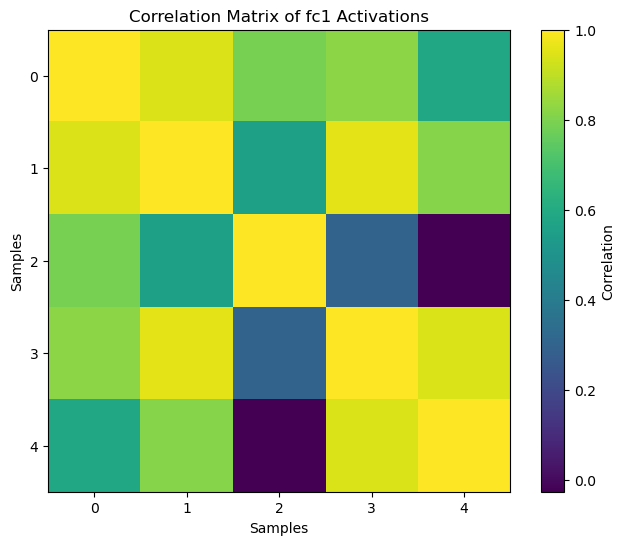

Metrics based on fc2 classification:
Accuracy: 60.000%
F1 Score: 0.583
Precision: 0.750
Recall: 0.667
Confusion Matrix:
[[1 2]
 [0 2]]
----
Metrics based on fc1 clustering:
Accuracy: 80.000%
F1 Score: 0.762
Precision: 0.875
Recall: 0.750
Confusion Matrix:
[[3 0]
 [1 1]]


In [1052]:
show_metrics(model, test_loader)

In [1007]:
transform_process = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize image data
])

In [ ]:
def process_video2(video_path):
    cap = cv2.VideoCapture(video_path)
    codec = 'MJPG'
    fourcc = cv2.VideoWriter_fourcc(*codec)
    out = cv2.VideoWriter('morse_spaceg.avi', fourcc, 20.0, (120,30))
    while True:
        ret, frame = cap.read()
        if ret:
            
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = detector(gray)
    
            # Iterate over detected faces
            for face in faces:
                eyes = get_cropped_eyes(gray, face)
                _, emb = model(transform_process(eyes).unsqueeze(0))
                distances = torch.cdist(emb, model.cluster_centers)
                pred_labels = distances.min(dim=1)[1]
                
                font                   = cv2.FONT_HERSHEY_SIMPLEX
                bottomLeftCornerOfText = (20,20)
                fontScale              = 0.6
                fontColor              = (255)
                thickness              = 1
                lineType               = 2
                text = ''
                if pred_labels.squeeze() == 0:
                    text =  ''#'closed'
                else:
                    text =  ''#'open'
                cv2.putText(eyes, text, 
                    bottomLeftCornerOfText, 
                    font, 
                    fontScale,
                    fontColor,
                    thickness,
                    lineType)
                out.write(cv2.cvtColor(eyes, cv2.COLOR_GRAY2BGR))
                cv2.imshow("Frame", cv2.cvtColor(eyes, cv2.COLOR_BGR2RGB))                
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    out.release()
    cv2.destroyAllWindows()

#process_video2("morse_b.avi")
process_video2(0)

tensor([0])
tensor([[ 1.6680, -1.2785]], grad_fn=<AddmmBackward0>)


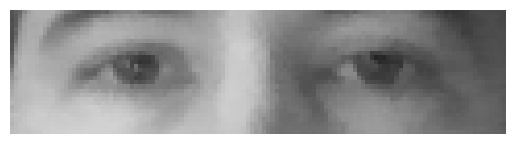

In [1008]:
image = cv2.imread("me_open2.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = detector(gray)    
# Iterate over detected faces
for face in faces:
    eyes = get_cropped_eyes(gray, face)
    _, emb = model(transform_process(eyes).unsqueeze(0))
    distances = torch.cdist(emb, model.cluster_centers)
    pred_labels = distances.min(dim=1)[1]
    print(pred_labels)
    print(_)
    #cv2.imshow("Frame", cv2.cvtColor(eyes, cv2.COLOR_BGR2RGB))
    plt.imshow(cv2.cvtColor(eyes, cv2.COLOR_GRAY2RGB))
    plt.axis('off')
    plt.show()

tensor([8])
torch.Size([1, 146, 1, 30, 120])
torch.Size([1, 30, 120])


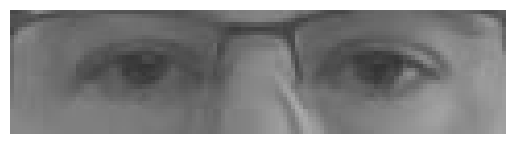

In [961]:
import os
import cv2
import torch
from torch.nn.utils.rnn import pad_sequence
from torchvision.datasets import VisionDataset
from torchvision.datasets.folder import default_loader

class VideoFolder(VisionDataset):
    def __init__(self, root, loader=default_loader, extensions=('avi', 'mp4'), transform=None, target_transform=None):
        super(VideoFolder, self).__init__(root, transform=transform, target_transform=target_transform)
        self.loader = loader
        self.extensions = extensions
        self.classes, self.class_to_idx = self._find_classes(self.root)
        self.samples = self._make_dataset(self.root, self.class_to_idx, extensions)
    
    def _find_classes(self, dir):
        classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx
    
    def _make_dataset(self, dir, class_to_idx, extensions):
        samples = []
        for target_class in sorted(class_to_idx.keys()):
            class_dir = os.path.join(dir, target_class)
            if not os.path.isdir(class_dir):
                continue
            for root, _, fnames in sorted(os.walk(class_dir)):
                for fname in fnames:
                    if self._has_video_extension(fname):
                        path = os.path.join(root, fname)
                        item = (path, class_to_idx[target_class])
                        samples.append(item)
        return samples
    
    def _has_video_extension(self, filename):
        return any(filename.endswith(ext) for ext in self.extensions)
    
    def __getitem__(self, index):
        path, target = self.samples[index]
        frames = self._load_frames(path)
        if self.transform is not None:
            frames = [self.transform(frame) for frame in frames]
        return frames, target
    
    def __len__(self):
        return len(self.samples)
    
    def _load_frames(self, video_path):
        cap = cv2.VideoCapture(video_path)
        frames = []
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(frame)
        cap.release()
        return frames

    # Gives a consistent sequence length to video frames per batch, but varied across batches
    def collate_fn(batch):
        # Sort batch by sequence length (number of frames)
        batch.sort(key=lambda x: len(x[0]), reverse=True)
        # Separate frames and targets
        frames, targets = zip(*batch)
        # Pad frames with zeros to make them equal length
        padded_frames = pad_sequence([torch.tensor(np.array(f)) for f in frames], batch_first=True)
        # Convert targets to tensor
        targets = torch.tensor(targets)
        return padded_frames, targets

    #  Gives an absolute size to the sequence length of video frames
    def collate_fn2( batch):
        # Sort batch by sequence length (number of frames)
        batch.sort(key=lambda x: len(x[0]), reverse=True)
        # Separate frames and targets
        frames, targets = zip(*batch)
        
        # Pad frames with zeros to make them equal length, with a maximum size of 200
        max_size = 200
        padded_frames = []
        for frame in frames:
            if len(frame) > max_size:
                frame = frame[:max_size]  # Trim frames to maximum size
            else:
                # Pad frames with zeros
                padding = torch.zeros(*frame[0].shape)
                frame.extend([padding] * (max_size - len(frame)))
            print(len(frame))
            print(frame[-2].shape)
            print(frame[-1].shape)
            padded_frames.append(torch.stack(frame))
    
        # Convert targets to tensor
        targets = torch.tensor(targets)
        return torch.stack(padded_frames), targets

        
root_dir = './morse2'
video_dataset = VideoFolder(root=root_dir, transform=transform_process)

# Create a DataLoader
batch_size = 1
video_data_loader = torch.utils.data.DataLoader(video_dataset, batch_size=batch_size, shuffle=True, collate_fn=VideoFolder.collate_fn)

inputs, classes = next(iter(video_data_loader))
#print(inputs)
print(classes)
print(inputs.shape)
frame = inputs[0][0]
print(frame.shape)
frame = (frame.permute(1,2,0) + 1)/2*255

plt.imshow(cv2.cvtColor(np.uint8(frame), cv2.COLOR_GRAY2RGB))
plt.axis('off')
plt.show()

In [ ]:
import copy
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

class LRCN(nn.Module):
    def __init__(self, cnn_model, hidden_size, n_layers, n_classes, dropout_rate=0.0):
        super(LRCN, self).__init__()

        base_cnn = cnn_model

        for param in base_cnn.parameters():
            param.requires_grad = False
        num_features = base_cnn.fc2.in_features
        base_cnn.fc2 = Identity()
        self.base_model = base_cnn
        self.rnn = nn.LSTM(num_features, hidden_size, n_layers, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, n_classes)
        self.state = None

    def forward(self, x):
        bs, ts, c, h, w = x.shape   # batch_size, time_steps, channel, height, width
        idx = 0
        _, y = self.base_model((x[:, idx]))
        if self.state is None:
            out, (hn, cn) = self.rnn(y.unsqueeze(1))
        else:
            hn, cn = self.state
            out, (hn, cn) = self.rnn(y.unsqueeze(1), (hn.detach().to(device), cn.detach().to(device)))
        
        #self.state = (hn, cn)
        for idx in range(1, ts):            
            _, y = self.base_model((x[:, idx]))
            out, (hn, cn) = self.rnn(y.unsqueeze(1), (hn, cn))
            #self.state = (hn, cn)
        out = out[:, -1]
        out = self.fc(out)
        return out

loss_fn = nn.CrossEntropyLoss(reduction='sum')
lrcn = LRCN(copy.deepcopy(model), 80, 1, 27)

optimizer = torch.optim.Adam(lrcn.parameters(), lr=0.001)

X0, y0 = next(iter(video_data_loader))
output=lrcn(X0)
pred = output.argmax(dim=1, keepdim=False)
print(output.shape)
print(pred.shape)
#print(output)
print(pred)
print(y0)
print(loss_fn(output,y0))

In [ ]:
import torch
import torch.nn as nn
import math
import copy

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

class MorseTransformerEncoder(nn.Module):
    def __init__(self, cnn_model, num_layers, num_heads, output_dim, max_seq_length):
        super(MorseTransformerEncoder, self).__init__()
        base_cnn = cnn_model
        for param in base_cnn.parameters():
            param.requires_grad = False
        hidden_dim = base_cnn.fc2.in_features
        base_cnn.fc2 = Identity()
        self.base_model = base_cnn
        
        #self.embedding = nn.Embedding(input_dim, hidden_dim)
        self.positional_encoding = PositionalEncoding(hidden_dim, max_seq_length)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, src):
        # src: (batch_size, seq_length, channel, height, width)
        batch_size, seq_length, _, height, width = src.size()
        src = src.view(batch_size * seq_length, 1, height, width)  # Reshape to (batch_size * seq_length, channel, height, width)
        
        # Loop through each frame and pass it through the embedder
        embeddings = []
        for i in range(batch_size * seq_length):
            _, embedding = self.base_model(src[i])  # Pass each frame through the embedder
            embeddings.append(embedding)
        embeddings = torch.stack(embeddings)  # Stack embeddings into a tensor
        embeddings = embeddings.view(seq_length, batch_size, -1)  # Reshape to (seq_length, batch_size, hidden_dim)
        
        embeddings = self.positional_encoding(embeddings)  # Add positional encoding
        output = self.transformer_encoder(embeddings)  # Output: (seq_length, batch_size, hidden_dim)
        output = self.fc(output[-1])  # Take only the last output for each sequence
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# Example usage:
input_dim = 100  # Assuming 100 different Morse code symbols
#hidden_dim = 256
num_layers = 4
num_heads = 8
output_dim = 27  # Assuming 26 English letters
max_seq_length = 100  # Maximum sequence length
modelx = MorseTransformerEncoder(copy.deepcopy(model), num_layers, num_heads, output_dim, max_seq_length)

# Generate some example input data
input_data, y0 = next(iter(video_data_loader))
# Forward pass
output = modelx(input_data)
print(input_data.shape)
print(output.shape)  # Output: (batch_size, output_dim)

optimizer = torch.optim.Adam(modelx.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [ ]:
from tqdm import tqdm

lrcn.to(device)
optimizer = torch.optim.Adam(lrcn.parameters(), lr=0.001)

num_epochs = 5 # 250
for epoch in tqdm(range(num_epochs)):
    loss_sum = 0
    loss_count = 0
    acc_sum = 0
    test_loss_sum = 0
    test_loss_count = 0
    test_acc_sum = 0

    lrcn.train()
    optimizer.zero_grad()
    loss = None
    for data, labels in video_data_loader:
        data = data.to(device)
        labels = labels.to(device)        
        
        prediction = modelx(data) # lrcn(data)
        loss_temp = loss_fn(prediction, labels)
        loss_sum += loss_temp.item()
        if loss is None:
            loss = loss_temp            
        else:
            loss += loss_temp        
        
        loss_count += len(labels)
        acc_sum += (prediction.argmax(1) == labels).type(torch.float).sum().item()
        
    loss.backward()
    optimizer.step()
    
    lrcn.eval()
    with torch.no_grad():
        for data, labels in video_data_loader:
            data = data.to(device)
            labels = labels.to(device)
            prediction = modelx(data) # lrcn(data)
            loss = loss_fn(prediction, labels)
            
            test_loss_sum += loss.item()
            test_loss_count += len(labels)
            test_acc_sum += (prediction.argmax(1) == labels).type(torch.float).sum().item()
    
    #scheduler.step(loss_sum/loss_count)
    if epoch % 1 == 0:
        print(f"Epoch {epoch}, Loss: {loss_sum/loss_count}, Acc: {acc_sum/loss_count}")
        print(f"Epoch {epoch}, Test Loss: {test_loss_sum/test_loss_count}, Acc: {test_acc_sum/test_loss_count}")

In [962]:
lrcn.eval()
classes = video_dataset.classes
with torch.no_grad():
    for data, labels in video_data_loader:
#data, labels = next(iter(video_data_loader))
        data = data.to(device)
        labels = labels.to(device)
        output=lrcn(data)
        pred = output.argmax(dim=1, keepdim=False)
        print(np.array(classes)[labels.numpy()])
        print(np.array(classes)[pred.numpy()])

['o']
['o']
['s']
['s']
['j']
['j']
['e']
['c']
['i']
['i']
['f']
['f']
['a']
['a']
['w']
['w']
['u']
['u']
['p']
['p']
['q']
['q']
['f']
['f']
['d']
['d']
['z']
['z']
['j']
['j']
['o']
['o']
['t']
['t']
['g']
['g']
['n']
['n']
['u']
['u']
['r']
['r']
['g']
['g']
['y']
['y']
['h']
['h']
['c']
['c']
['r']
['r']
['v']
['v']
['y']
['y']
['q']
['q']
['_']
['_']
['n']
['s']
['_']
['i']
['h']
['h']
['e']
['e']
['a']
['a']
['t']
['t']
['x']
['x']
['m']
['m']
['s']
['s']
['v']
['v']
['w']
['w']
['z']
['z']
['l']
['l']
['b']
['b']
['k']
['k']
['i']
['i']
['l']
['l']
['d']
['d']
['c']
['c']
['x']
['x']
['k']
['k']
['p']
['p']
['b']
['b']
['m']
['m']


In [ ]:
torch.save(model.state_dict(), "base_model.pt")

In [952]:
lrcn.load_state_dict(torch.load("lrcn_model_cpu.pt"))

<All keys matched successfully>

In [1009]:
def decode_morse_code(morse_code):
    # Lookup table or dictionary to decode Morse code to English letters
    morse_to_eng = {
        '.-': 'A', '-...': 'B', '-.-.': 'C', '-..': 'D', '.': 'E',
        '..-.': 'F', '--.': 'G', '....': 'H', '..': 'I', '.---': 'J',
        '-.-': 'K', '.-..': 'L', '--': 'M', '-.': 'N', '---': 'O',
        '.--.': 'P', '--.-': 'Q', '.-.': 'R', '...': 'S', '-': 'T',
        '..-': 'U', '...-': 'V', '.--': 'W', '-..-': 'X', '-.--': 'Y',
        '--..': 'Z'
    }
    return morse_to_eng.get(morse_code, '')

def inference_video(video_path, dot_threshold=5, end_threshold=10, precropped_video=False):
    
    cap = cv2.VideoCapture(video_path)
    codec = 'MJPG'
    #fourcc = cv2.VideoWriter_fourcc(*codec)
    #out = cv2.VideoWriter('morse_spaceg.avi', fourcc, 20.0, (120,30))
    empty_count = 0
    prv_letter = '_'
    words = ''
    
    prv_state = 1
    state_count = 0
    symbols = []
    
    while True:
        ret, frame = cap.read()
        if ret:            
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = detector(gray)
            if precropped_video:
                faces = [1] # force face loop
            empty_count += 1
            # Iterate over detected faces
            for face in faces:
                empty_count = 0
                
                if not precropped_video:
                    eyes = get_cropped_eyes(gray, face)
                else:
                    eyes = gray # use the precropped frame
                    
                with torch.no_grad():
                    data_in = transform_process(eyes).unsqueeze(0)                    
                    _, emb = model(data_in)
                    distances = torch.cdist(emb, model.cluster_centers)
                    open_shut = distances.min(dim=1)[1].squeeze()
                                    
                if open_shut == 0: #closed
                    if prv_state == 1:
                        #newly closed
                        state_count = 0
                    else:
                        #continued close
                        state_count += 1
                else: #open
                    if prv_state == 0:
                        #end of close, interpret
                        if state_count < dot_threshold:
                            #dot
                            symbols.append('.')
                        else:
                            #dash
                            symbols.append('-')
                        state_count = 0
                    else:
                        #still open
                        state_count += 1                        
                        if state_count > end_threshold:
                            state_count = 0
                            if len(symbols) > 0:
                                #find letter
                                code = ''.join(symbols)
                                symbols = []
                                letter = decode_morse_code(code)
                                words += letter
                                prv_letter = letter
                            else:
                                #word space
                                if prv_letter != '_':
                                    words += '_'
                                    prv_letter = '_'
                                    
                            ## if lrcn worked then the below may handle decoding
                            #if len(frame_buffer) > 0:
                            #    #find letter
                            #    code = torch.stack(frame_buffer).permute(1,0,2,3,4)
                            #    output = lrcn(code[:,:-10])
                            #    letter = output.argmax(dim=1, keepdim=False)
                            #    words2 += video_dataset.classes[letter]
                            #    prv_letter2 = letter
                                    
                prv_state = open_shut     
                if len(words) > 20:
                    words = '' #clear the clutter
                    
                ## frame = cv2.resize(frame,(800,100)) # resize precropped training videos
                font                   = cv2.FONT_HERSHEY_SIMPLEX
                bottomLeftCornerOfText = (20,20)
                fontScale              = 0.6
                fontColor              = (255)
                thickness              = 1
                lineType               = 2

                blink = "O"
                if open_shut == 0:
                    blink = "-"
                text = f"{blink} :: {words}"
                
                cv2.putText(frame, text, 
                    bottomLeftCornerOfText, 
                    font, 
                    fontScale,
                    fontColor,
                    thickness,
                    lineType)
                #out.write(cv2.cvtColor(eyes, cv2.COLOR_GRAY2BGR))
                
                cv2.imshow("Frame", cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                
        else:
            empty_count += 1
            
        if cv2.waitKey(1) & 0xFF == ord('q') or empty_count > 300:
            if empty_count > 50:
                print(f"empty count: {empty_count}")
            break
    cap.release()
    #out.release()
    cv2.destroyAllWindows()

#inference_video("./morse/morse_c.avi", 9, 8, precropped_video=True)
inference_video(0)